In [9]:
import time
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

import load_data as data

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

mat/MaiaFall1.mat
mat/MaiaFall2.mat
mat/MaiaFall3.mat
mat/MaiaFall4.mat
mat/MaiaFall5.mat
mat/MaiaFall6.mat
mat/MaiaFall7.mat
mat/MaiaFall8.mat
mat/MaiaFall9.mat
mat/MaiaJump1.mat
mat/MaiaJump10.mat
mat/MaiaJump2.mat
mat/MaiaJump3.mat
mat/MaiaJump4.mat
mat/MaiaJump5.mat
mat/MaiaJump6.mat
mat/MaiaJump7.mat
mat/MaiaJump8.mat
mat/MaiaJump9.mat
mat/MaiaTurn1.mat
mat/MaiaTurn10.mat
mat/MaiaTurn2.mat
mat/MaiaTurn3.mat
mat/MaiaTurn4.mat
mat/MaiaTurn5.mat
mat/MaiaTurn6.mat
mat/MaiaTurn7.mat
mat/MaiaTurn8.mat
mat/MaiaTurn9.mat
mat/SliuFall1.mat
mat/SliuFall10.mat
mat/SliuFall2.mat
mat/SliuFall3.mat
mat/SliuFall4.mat
mat/SliuFall5.mat
mat/SliuFall6.mat
mat/SliuFall7.mat
mat/SliuFall8.mat
mat/SliuFall9.mat
mat/SliuJump1.mat
mat/SliuJump10.mat
mat/SliuJump2.mat
mat/SliuJump3.mat
mat/SliuJump4.mat
mat/SliuJump5.mat
mat/SliuJump6.mat
mat/SliuJump7.mat
mat/SliuJump8.mat
mat/SliuJump9.mat
mat/SliuTurn1.mat
mat/SliuTurn10.mat
mat/SliuTurn2.mat
mat/SliuTurn3.mat
mat/SliuTurn4.mat
mat/SliuTurn5.mat
mat/S

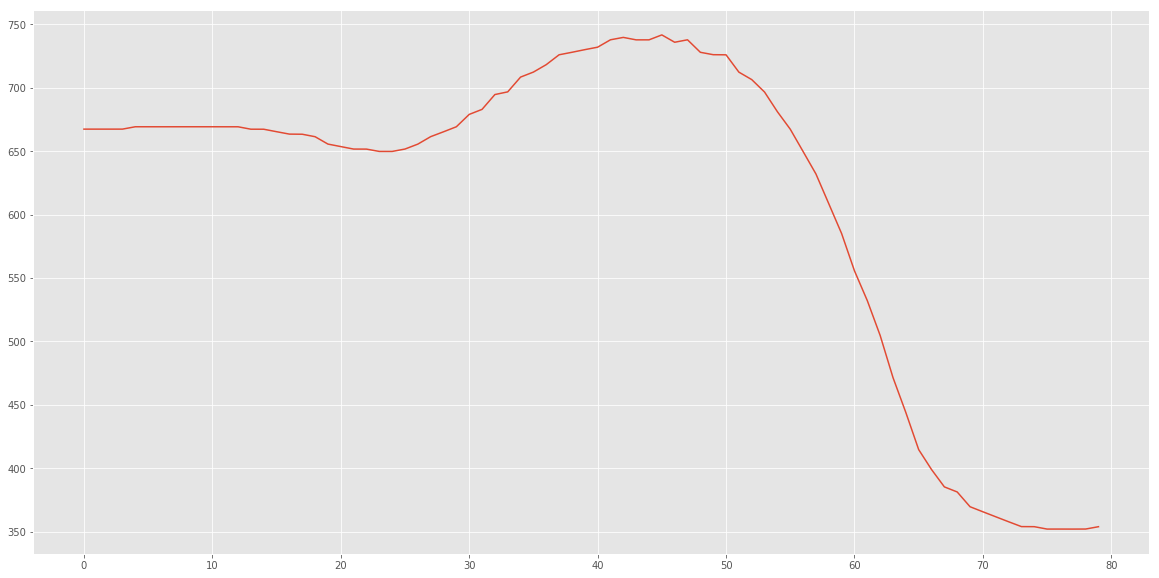

In [10]:
# n different points we want to cluster
# We have 59 points in all 3 categories * 2 people * 10 repetitions (maia_fall only had 9)
n = 59
# Tensor length of 80 since that's how many frames we decided on--easily modifiable
ts_len = 80

# Starting off with just one point so that it's easier to follow along with tutorials
# Will switch to more than one point later
# joint_index specifies which of the 36 joints we want, 0 is nose
# Find corresponding values at https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md
joint_index = 0 
noses = data.get_one_keypoint(n, joint_index)
# should produce (80,)
# print(noses[0].shape)
plt.plot(noses[0])

# # Normalize everything between 0 and 1
# signals += np.abs(np.min(signals))
# signals /= np.max(signals)
# print(signals[0].shape)
# plt.plot(signals[0])

In [11]:
# MSE - mean squared error
def euclid_dist(t1, t2):
    return np.sqrt(((t1-t2)**2).sum(axis = 1))

def calc_centroids(data, centroids):
    dist = np.zeros([data.shape[0], centroids.shape[0]])
    for idx, centroid in enumerate(centroids): 
        dist[:, idx] = euclid_dist(centroid, data)
    return np.array(dist)
def closest_centroids(data, centroids): 
    dist = calc_centroids(data, centroids) 
    return np.argmin(dist, axis = 1)
def move_centroids(data, closest, centroids):
    k = centroids.shape[0]
    new_centroids = np.array([data[closest == c].mean(axis = 0) for c in np.unique(closest)])
    if k - new_centroids.shape[0] > 0:
       print("adding {} centroid(s)".format(k - new_centroids.shape[0]))
       additional_centroids = data[np.random.randint(0, data.shape[0], k - new_centroids.shape[0])] 
       new_centroids = np.append(new_centroids, additional_centroids, axis = 0)
    return new_centroids

def k_means(data, num_clust, num_iter):
    # signals.shape[0] = 10,000 same as n
    centroids = data[np.random.randint(0, data.shape[0], num_clust)]
    last_centroids = centroids
    for n in range(num_iter):
        closest = closest_centroids(data, centroids)
        centroids = move_centroids(data, closest, centroids)
        if not np.any(last_centroids != centroids):
           print("early finish!")
           break
        last_centroids = centroids 
        
    return centroids


In [12]:
t1 = time.time()
centroids = k_means(noses, 6, 5)
t2 = time.time()
print("Took {} seconds".format(t2 - t1))

Took 0.003197908401489258 seconds
